In [62]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (16, 10)

In [63]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from math import exp, log

## Logistic Regression
#### Pen-based Recognition of handwritten digits dataset

In [64]:
loaded = load_digits()

In [65]:
images = loaded.images
data = loaded.data
targets = loaded.target
target_names = loaded.target_names

#### Visualize digits

In [66]:
def plot_image(image, **kwargs):
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest', **kwargs)
    None    

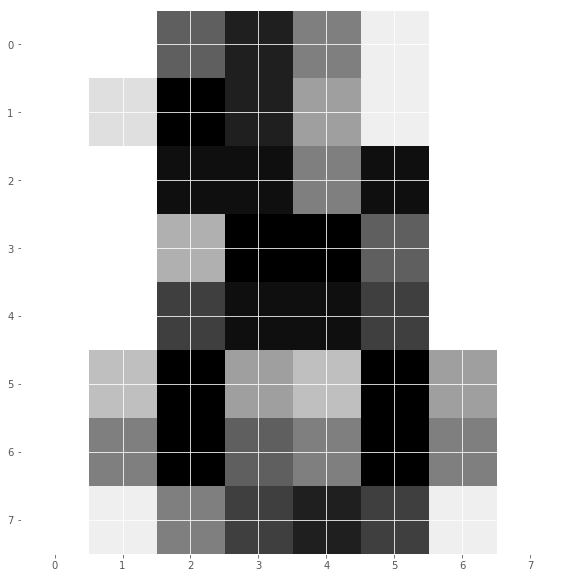

In [67]:
plot_image(images[-1])

---

### Incorporate a Logit

In [68]:
def sigmoid(val, threshold):
    """ This encoder with use the sigmoid function """
    sig = 1/(1 + exp(-val))
    return 0 if sig - threshold < 0 else 1
#     return 0 if sig <= threshold else 1

In [69]:
def image_logit(image, threshold=0.9):
    return [[sigmoid(pixel, threshold) for pixel in pixels] for pixels in image]

In [70]:
def vec_logit(vec, threshold=0.9):
    return [sigmoid(val, threshold) for val in vec]

#### Test Sigmoid

In [71]:
test_digit = images[-1]

In [72]:
test_encoded = image_logit(test_digit)

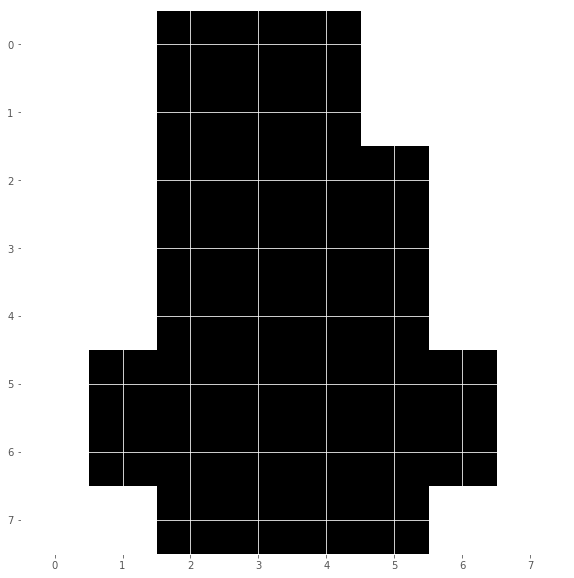

In [73]:
plot_image(test_encoded)

---

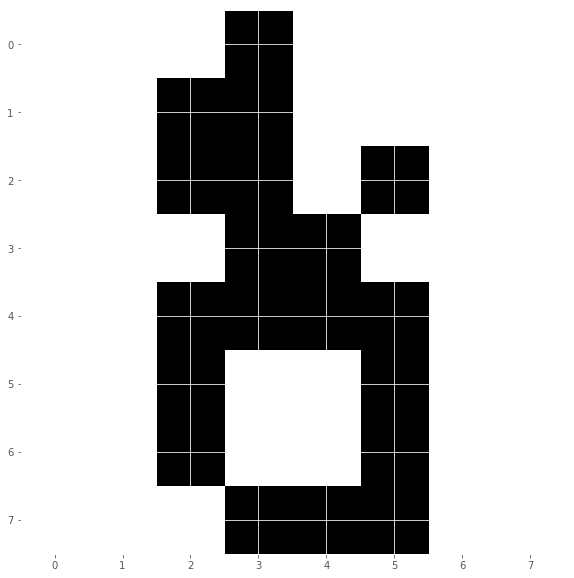

In [74]:
plot_image(image_logit(test_digit, 0.99999))

---

### Softmax

In [75]:
def softmax(vec):
    """ Scaling a vector using 'softmax'
    
    All values of the scaled vector should sum to one
    :param vec: list of numbers
    :return: scaled list of numbers
    """
    
    vec_sum = sum(vec)
    return np.array([i/vec_sum for i in vec])
#     vec_exp = np.exp(vec)
#     return vec_exp/np.sum(vec_exp)

In [76]:
sum(softmax(list(range(10)))) == 1

True

In [77]:
def multi_softmax(multi_vec):
    """ Scaling a multidimensional vector using 'softmax'
    
    All lists of the scaled multi_vec should sum to one
    :param multi_vec: list of list of numbers
    :return: scaled multi_vec
    """
    
    return np.array([softmax(vec) for vec in multi_vec])

---

### Process Data

#### Create 'One Hot Encoder' used for classifying images
- Convert each target name into a vector of '0's with a single identifying '1' for a target's respective index

In [78]:
def one_hot(targets_, target_names_):
    encode = lambda x: [1 if i == x else 0 for i in range(len(target_names_))]
    
    return list(map(encode, targets_))

In [79]:
def one_cold(hot):
    return np.argmax(hot)

In [80]:
one_hot(targets[-10:-4], target_names)

[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

In [81]:
encoded_targets = np.array(one_hot(targets, target_names))

#### Scale image data

In [82]:
scaler = StandardScaler()

In [83]:
scaled_data = scaler.fit_transform(data)

#### Apply logit function for 'cleaning' images

In [84]:
logit_data = np.array([vec_logit(vec, 0.9995) for vec in scaled_data])

In [85]:
logit_images = [image_logit(image, 0.9995) for image in images]

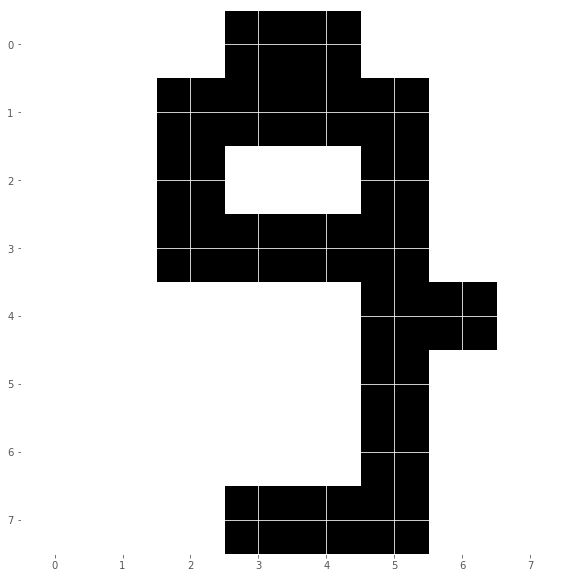

In [86]:
plot_image(logit_images[-5])

### Setup training/validation

In [87]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, encoded_targets)
# X_train, X_test, y_train, y_test = train_test_split(logit_data, encoded_targets)

### Apply Gradient Descent to make predictions of digits

In [88]:
def gradient_descent(X_mat, y_mat, learning_rate, break_early=True, threshold = 5e-5, report=False):
    n_observations = len(X_mat)
    n_classes = y_mat.shape[1]
    n_features = len(X_mat[1])
    
    total_error = np.zeros((n_observations, y_mat.shape[1]))
    
    W_estimate = np.zeros((n_features, y_mat.shape[1]))
    b_estimate = np.zeros(y_mat.shape[1])
   
    for i, (x, y) in enumerate(zip(X_mat, y_mat)):
        y_est = np.add(np.dot(x, W_estimate), b_estimate)
        est_term =  np.subtract(y_est, y)

        b_gradient = est_term
        W_gradient = np.outer(x, est_term)

        b_estimate = np.subtract(b_estimate, learning_rate*b_gradient)
        W_estimate = np.subtract(W_estimate, learning_rate*W_gradient)

        total_error[i] = np.mean((est_term)**2)
        
        if report and (i+1) % 100 == 0:
            report_epoch(X_mat[:i], y_mat[:i], W_estimate, b_estimate, epoch=i+1)

    return (W_estimate, b_estimate, total_error)

In [89]:
W, b, err = gradient_descent(X_train, y_train, learning_rate=0.0009)

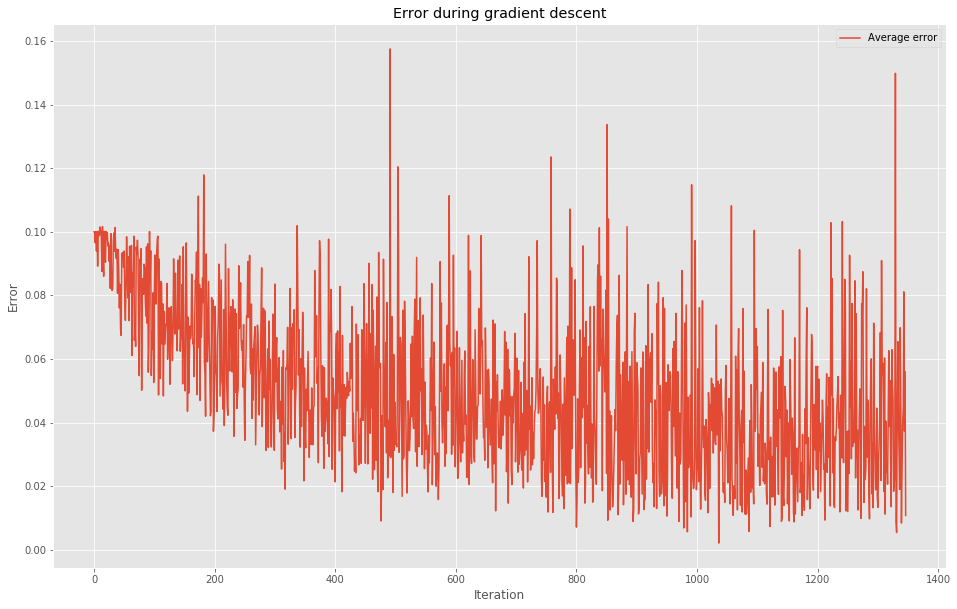

In [90]:
plt.plot(np.apply_over_axes(np.average, err, 1), label="Average error")
plt.title("Error during gradient descent")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend()
None

---

### Generate Predictions with trained model

In [91]:
def predict(X_, W_, b_):
    if len(X_.shape) == 1:
        res = np.add(np.dot(X_, W_), b_)
        return np.argmax(softmax(res))
    else:
        res = np.add(np.dot(X_, W_), b_)
        return np.argmax(multi_softmax(res), axis=1)

In [92]:
print("The first 5 test values are {}".format([one_cold(y) for y in y_test[:5]]))
print("The first 5 predicted values are {}".format(predict(X_test[:5], W, b)))

The first 5 test values are [7, 5, 9, 7, 9]
The first 5 predicted values are [7 5 9 7 9]


---

### Evaluation of Predictions

#### Accuracy

In [93]:
def accuracy(y_hot, hot_predictions):
    return np.sum(y_hot * hot_predictions)/np.sum(y_hot.T)

In [94]:
print("Accuracy score of model: {:.2f}%".format(100 * accuracy(y_test[:5],  one_hot(predict(X_test[:5], W, b), target_names))))

Accuracy score of model: 100.00%


#### Negative Log Likelihood

In [95]:
def nll(Y_true, Y_pred):
    """ Apply 'Negative Log Likelihood' to true values and predictions
    
    - Confident yet incorrect prediction is a high positive number
    - Nearly perfect prediction is close to 0
    
    :param Y_true: list of ground truth values
    :param Y_pred: list of predicted values
    :return (float) average negative log likelihood
    """
    pass

In [96]:
from sklearn.metrics import log_loss

In [97]:
print("Loss in model: {:.3e}".format(log_loss(y_test, softmax(np.dot(X_test, W) + b))))

Loss in model: 7.548e-01


---

## All together

#### Report Epochs - used in Gradient Descent to track accuracy and loss as the model is trained

In [98]:
def report_epoch(X_, y_, W_, b_, epoch=None):
    preds = predict(X_, W_, b_)
    acc_report = "\tModel accuracy: {:.2f}%".format(100 * accuracy(y_, one_hot(preds, target_names)))
    loss_report = "\tModel loss: \t{:.4e}".format(log_loss(y_, softmax(np.dot(X_, W_) + b_)))
    
    epoch_title = "" if epoch is None else " Epoch {} ".format(epoch)
    banner = "#"*(20-len(epoch_title)) 
    full_title = epoch_title + banner
    
    print("\n\t" + full_title, acc_report, loss_report)


In [99]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, encoded_targets)

W, b, err = gradient_descent(X_train, y_train, learning_rate=0.0009, report=True)

predictions = predict(X_test, W, b)

# Convert one hot encoded test values back to digits
cold_test = [one_cold(y) for y in y_test]

prediction_cm = confusion_matrix(cold_test, predictions)


	 Epoch 100 ######### 	Model accuracy: 80.81% 	Model loss: 	3.0884e+00

	 Epoch 200 ######### 	Model accuracy: 92.96% 	Model loss: 	7.9848e-01

	 Epoch 300 ######### 	Model accuracy: 91.64% 	Model loss: 	7.9128e-01

	 Epoch 400 ######### 	Model accuracy: 92.98% 	Model loss: 	7.4562e-01

	 Epoch 500 ######### 	Model accuracy: 93.19% 	Model loss: 	7.2760e-01

	 Epoch 600 ######### 	Model accuracy: 92.65% 	Model loss: 	7.1804e-01

	 Epoch 700 ######### 	Model accuracy: 93.28% 	Model loss: 	7.0969e-01

	 Epoch 800 ######### 	Model accuracy: 92.87% 	Model loss: 	7.5426e-01

	 Epoch 900 ######### 	Model accuracy: 93.10% 	Model loss: 	7.4756e-01

	 Epoch 1000 ######## 	Model accuracy: 92.39% 	Model loss: 	7.1650e-01

	 Epoch 1100 ######## 	Model accuracy: 92.45% 	Model loss: 	6.9712e-01

	 Epoch 1200 ######## 	Model accuracy: 92.66% 	Model loss: 	7.2065e-01

	 Epoch 1300 ######## 	Model accuracy: 92.76% 	Model loss: 	6.9901e-01


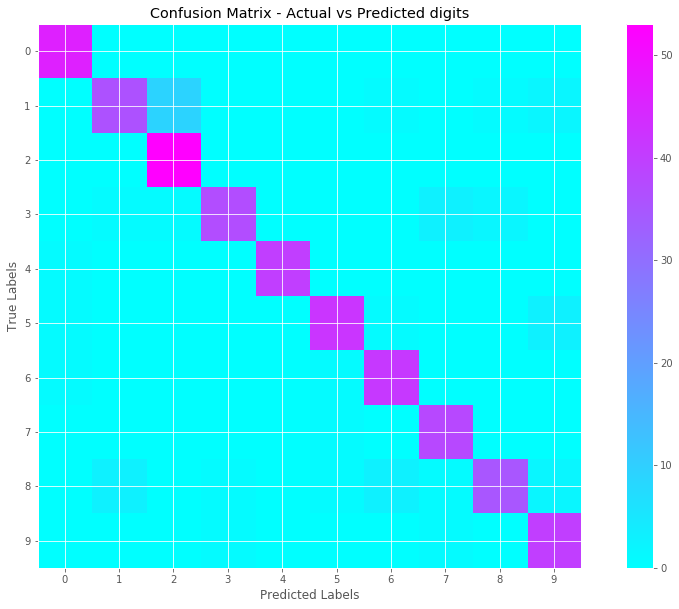

In [100]:
plt.imshow(prediction_cm, interpolation='nearest', cmap=plt.cm.cool)
plt.colorbar()
tick_marks = target_names
plt.xticks(target_names, target_names)
plt.yticks(target_names, target_names)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix - Actual vs Predicted digits")
None

---

In [101]:
results = pd.DataFrame().assign(actual=cold_test).assign(predicted=predictions)

In [102]:
misses = results[results.actual != results.predicted]

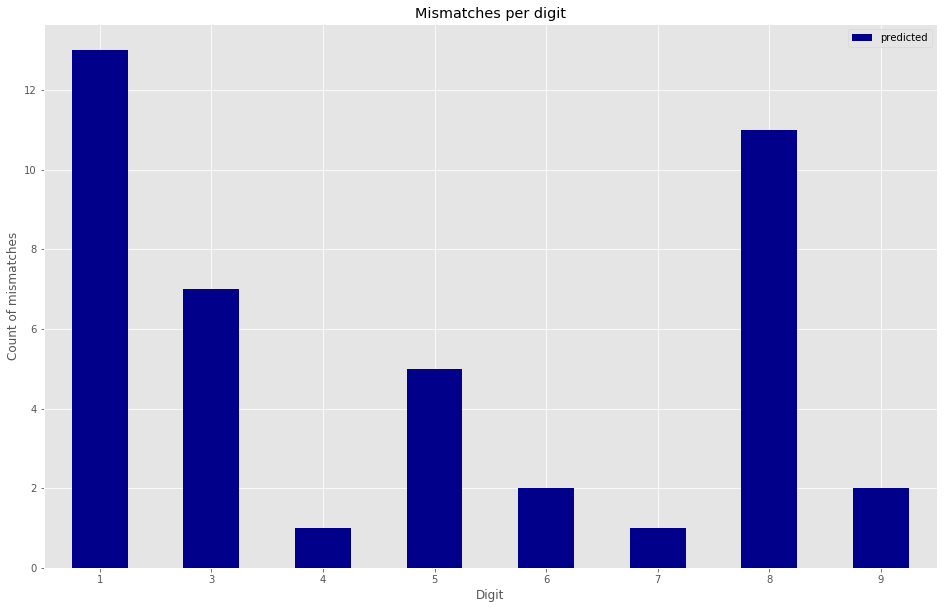

In [103]:
misses.groupby('actual').count().plot.bar(color='darkblue')
plt.title("Mismatches per digit")
plt.ylabel("Count of mismatches")
plt.xlabel("Digit")
plt.xticks(rotation=0)
None

---